In [43]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [44]:
import numpy as np
import pandas as pd

In [45]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [46]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [47]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [48]:
# inspect the tables
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [49]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [50]:
# reflect the tables
Base.prepare(engine, reflect=True)

In [51]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [52]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [53]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [54]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('station')
# print(columns)
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [55]:
# Use Inspector to print the column names and types
columns = inspector.get_columns('measurement')
# print(columns)
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [56]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Calculate the date 1 year ago from the last data point in the database
import warnings as wn
wn.filterwarnings("ignore")

# max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
# print(max_date)

# Calculate the date one year from the last date in data set.
prev_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= prev_date).statement

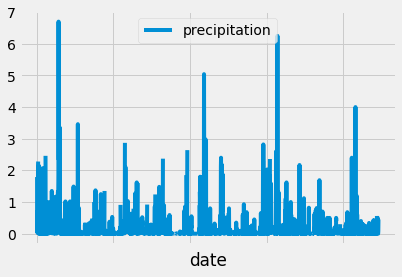

In [57]:
# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df = pd.read_sql_query(query, session.bind).sort_values(["date"])
# df = df.dropna(how='any') 
df = df.rename(columns={"prcp":"precipitation"})
df.set_index('date', drop=True, inplace=True)
# df.count()

# df.head(100)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x_compat=True)


![precipitation](Images/precipitation.png)

In [58]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe() 

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [59]:
# Design a query to show how many stations are available in this dataset?
session.query(Station).count()

9

In [60]:
measurements = session.query(Measurement.date, Measurement.station, Measurement.prcp, Measurement.tobs).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df_measurements = pd.read_sql_query(measurements, session.bind)
# df2_measurements = df_measurements.dropna(how='any') 
df2_measurements = df_measurements.rename(columns={"prcp":"precipitation"})
# df2_measurements.set_index('date', drop=True, inplace=True)
df2_measurements.head()

,date,station,precipitation,tobs
0,2010-01-01,USC00519397,0.08,65.0
1,2010-01-02,USC00519397,0.00,63.0
2,2010-01-03,USC00519397,0.00,74.0
3,2010-01-04,USC00519397,0.00,76.0
4,2010-01-06,USC00519397,NaN,73.0


In [61]:
stations = session.query(Station.station, Station.name).statement
df2_stations = pd.read_sql_query(stations, session.bind)
df2_stations


,station,name
0,USC00519397,"WAIKIKI 717.2, HI US"
1,USC00513117,"KANEOHE 838.1, HI US"
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US"
3,USC00517948,"PEARL CITY, HI US"
4,USC00518838,"UPPER WAHIAWA 874.3, HI US"
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US"
6,USC00519281,"WAIHEE 837.5, HI US"
7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US"
8,USC00516128,"MANOA LYON ARBO 785.2, HI US"


In [62]:
df_combined = pd.merge(df2_measurements, df2_stations, on="station", how="left")
df_combined.head()

,date,station,precipitation,tobs,name
0,2010-01-01,USC00519397,0.08,65.0,"WAIKIKI 717.2, HI US"
1,2010-01-02,USC00519397,0.00,63.0,"WAIKIKI 717.2, HI US"
2,2010-01-03,USC00519397,0.00,74.0,"WAIKIKI 717.2, HI US"
3,2010-01-04,USC00519397,0.00,76.0,"WAIKIKI 717.2, HI US"
4,2010-01-06,USC00519397,NaN,73.0,"WAIKIKI 717.2, HI US"


In [63]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
df_groupby = df_combined.groupby('station')

# # Count how many times each maker appears in our group
df_groupby['station'].count().sort_values(ascending=False)



station
USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [64]:
measurements2 = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').statement

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
df3_measurements = pd.read_sql_query(measurements2, session.bind)
# df4_measurements = df3_measurements.dropna(how='any') 
df4_measurements = df3_measurements.rename(columns={"prcp":"precipitation"})
# df2_measurements.set_index('date', drop=True, inplace=True)
df4_measurements.head()

,date,station,tobs
0,2010-01-01,USC00519281,70.0
1,2010-01-02,USC00519281,62.0
2,2010-01-03,USC00519281,74.0
3,2010-01-04,USC00519281,75.0
4,2010-01-05,USC00519281,74.0


In [65]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
min_temp = df4_measurements['tobs'].min()
max_temp = df4_measurements['tobs'].max()
avg_temp = round(df4_measurements['tobs'].mean(),1)

print('The lowest temperature at station USC00519281 was:', min_temp)
print('The highest temperature at station USC00519281 was:', max_temp)
print('The average temperature at station USC00519281 was:', avg_temp)


The lowest temperature at station USC00519281 was: 54.0
The highest temperature at station USC00519281 was: 85.0
The average temperature at station USC00519281 was: 71.7


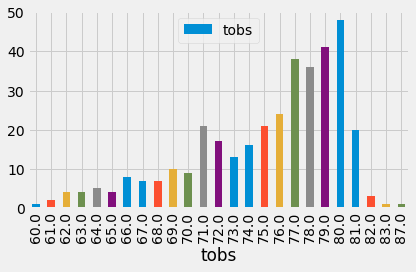

In [66]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.
# Plot the results as a histogram with bins=12.
query2 = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
    filter(Measurement.date >= prev_date).statement

df_tobs = pd.read_sql_query(query2, session.bind).sort_values(["date"])
df_tobs_groupby = df_tobs.groupby('station')

# # Count how many times each maker appears in our group
df_tobs_groupby['tobs'].count().sort_values(ascending=False)

query3 = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519397').\
    filter(Measurement.date >= prev_date).statement

df_tobs_USC00519397 = pd.read_sql_query(query3, session.bind)
df_tobs_USC00519397_groupby = df_tobs_USC00519397.groupby('tobs')
df_tobs_USC00519397_groupby_count = df_tobs_USC00519397_groupby['tobs'].count()#.sort_values(ascending=False)
# df_tobs_USC00519397_groupby_count
           
df_tobs_USC00519397_groupby_count.plot.bar()
ax1 = plt.axes()
x_axis = ax1.axes.get_xaxis()
# x_axis.set_visible(False)
plt.legend(loc="upper center")
plt.tight_layout()
plt.show()

![precipitation](Images/station-histogram.png)